### Importing required packages

In [9]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from collections import Counter, OrderedDict
from torchtext.vocab import vocab
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import urllib.request
from zipfile import ZipFile 
import os
from pathlib import Path

In [2]:
np.set_printoptions(precision=4, suppress=True)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Some Hyperparameters

In [5]:
VOCAB_SIZE = 25000
THRESHOLD_FREQ = 5
BATCH_SIZE = 32

### Importing data

In [6]:
!pip install gdown

In [7]:
!gdown 1ZDFmDZDOi_hrfXrKYHjt9RorHBEcT1mq

Downloading...
From: https://drive.google.com/uc?id=1ZDFmDZDOi_hrfXrKYHjt9RorHBEcT1mq
To: /kaggle/working/imdb_data.csv
100%|██████████████████████████████████████| 66.0M/66.0M [00:00<00:00, 83.8MB/s]


In [10]:
df = pd.read_csv(Path(os.path.join(os.getcwd(),'imdb_data.csv')))
df.head()

,Review,Rating,Sentiment
0,Imagine The Big Chill with a cast of twenty-so...,2,0
1,I'd have to say that I've seen worse Sci Fi Ch...,3,0
2,Director Fabio Barreto got a strange Academy N...,1,0
3,Pretty bad PRC cheapie which I rarely bother t...,4,0
4,This is a very intriguing short movie by David...,8,1


In [11]:
X = df['Review'].values 
y = df['Sentiment'].values 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

### Tokenizer

In [12]:
def tokenizer(text):
    # Replacing n't with not since it could be really important in sentiment analysis
    text = re.sub("n't", ' not ', text)
    # Removing URLs
    text = re.sub('(http).*\/', ' ', text)
    # Removing HTML tags
    text = re.sub('<[^>]*>', '', text)
    # Extracting emoticons
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|P|D|]|})', text)
    # Removing punctuations
    text = re.sub('[\W]+', ' ', text.lower())
    # Adding emoticons at end and converting :-) to :)
    text = text + ' ' + ' '.join(emoticons).replace('-', '')
    
    return text.split()

Vocabulary size = 85908


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


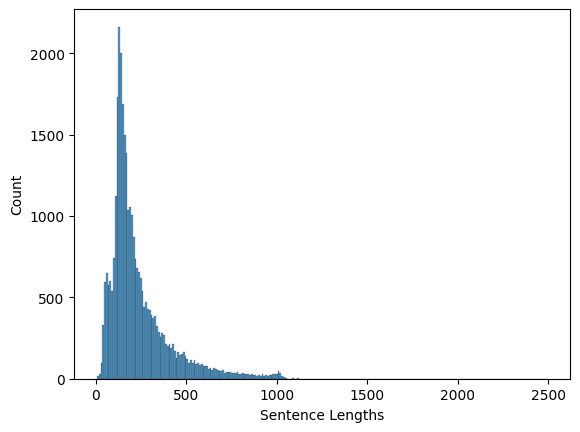

In [13]:
token_counter = Counter()
lengths = []
for review in X_train:
    tokens = tokenizer(review)
    lengths.append(len(tokens))
    token_counter.update(tokens)
print(f'Vocabulary size = {len(token_counter)}')
sns.histplot(lengths)
plt.xlabel('Sentence Lengths')
plt.show()

### Vocabulary class

In [14]:
class Vocabulary:    
    def __init__(self):
        self.vocabulary = None 
        
    def build_vocabulary(self, sentences):
        token_counter = Counter()
        for sentence in sentences:
            token_counter.update(tokenizer(sentence))
        sorted_by_freq_tuples = sorted(token_counter.items(), key=lambda x: x[1], reverse=True)[:VOCAB_SIZE]
        ordered_dict = OrderedDict(sorted_by_freq_tuples)
        specials = ['<PAD>', '<UNK>']
        self.vocabulary = vocab(ordered_dict, specials=specials, min_freq=THRESHOLD_FREQ)
        self.vocabulary.set_default_index(self.vocabulary['<UNK>'])
    
    def numericalize(self, sentence):
        tokenized_sentence = tokenizer(sentence)
        return [self.vocabulary[token] if token in self.vocabulary else self.vocabulary['<UNK>'] for token in tokenized_sentence] 
    
    def denumericalize(self, list):
        return [self.vocabulary.get_itos()[idx] if idx < len(self.vocabulary) else '<UNK>' for idx in list ]

In [15]:
v1 = Vocabulary()
v1.build_vocabulary(X_train)

### Using Glove Embeddings (creating weight matrix for nn.embedding)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [16]:
glove_dictionary = dict()
with open('/kaggle/working/glove.6B.100d.txt', 'r') as f:
    for line in f.readlines():
        line = line.split(' ')
        #print(line)
        glove_dictionary[line[0]] = np.array(line[1:], dtype=float)

In [17]:
vocab_size = len(v1.vocabulary)
weight_matrix = np.zeros((vocab_size, 100))
for word, idx in v1.vocabulary.get_stoi().items():
    if word == '<PAD>':
        continue
    if word in glove_dictionary:
        weight_matrix[idx] = glove_dictionary[word]
    else:
        weight_matrix[idx] = np.random.normal(size=(100,))
weight_matrix = torch.tensor(weight_matrix).float()

### Custom Dataset

In [18]:
class CustomDataset(Dataset):
    def __init__(self, reviews_list, sentiment_list, vocabulary):
        super(CustomDataset, self).__init__()
        self.reviews = reviews_list 
        self.targets = sentiment_list 
        self.v1 = vocabulary
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        review = self.reviews[index]
        target = self.targets[index]
        
        numericalized_review = torch.tensor(self.v1.numericalize(review))
        
        return numericalized_review, torch.tensor(target).unsqueeze(0).float()

### Collate Function

In [19]:
class Collate:
    def __init__(self, pad_idx) :
        self.pad_idx = pad_idx 
    
    def __call__(self, batch) :
        reviews = [item[0] for item in batch]
        reviews = pad_sequence(reviews, batch_first=True, padding_value=self.pad_idx)
        targets = torch.cat([item[1].unsqueeze(0) for item in batch], dim=0)
        return reviews, targets

### DataLoader

In [20]:
def get_dataloader(reviews_list, sentiment_list, vocabulary, batch_size, shuffle=True):
    dataset = CustomDataset(reviews_list, sentiment_list, vocabulary)
    pad_idx = dataset.v1.vocabulary['<PAD>']
    dataloader = DataLoader(
        dataset = dataset,
        batch_size = batch_size,
        shuffle = shuffle,
        collate_fn = Collate(pad_idx=pad_idx)
    )
    return dataloader

In [21]:
v1 = Vocabulary()
v1.build_vocabulary(X_train)
train_loader = get_dataloader(X_train, y_train, v1, BATCH_SIZE)
valid_loader = get_dataloader(X_valid, y_valid, v1, BATCH_SIZE)
test_loader = get_dataloader(X_test, y_test, v1, BATCH_SIZE)

### Checkpoint Functions

In [22]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

In [23]:
def load_checkpoint(model, optimizer, filename = 'checkpoint.pth.tar'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    max_accuracy = checkpoint['max_acc']
    best_model = checkpoint['best_model']
    return model, optimizer, max_accuracy, best_model

### Getting Accuracy

In [24]:
def get_accuracy(model, data_loader, loss_fn):
    total_correct = 0.0
    total_loss = 0.0
    with torch.no_grad():
        model.eval()
        for _, batch in enumerate(data_loader):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            y_preds = model(inputs)
            loss = loss_fn(y_preds, labels)
            total_loss += loss.item()*len(inputs)
            correct_counts = (torch.where(y_preds>0.5, 1, 0) == labels).float().sum().item()
            total_correct += correct_counts
    accuracy = total_correct/len(data_loader.dataset)*100
    avg_loss = total_loss/len(data_loader.dataset)  
    return accuracy, avg_loss

### Training

In [25]:
def training(model, model_name, optimizer, scheduler, loss_fn, train_data_loader, valid_data_loader, load_model=False, save_model=True, num_epochs = 10, patience=5):
    history = []
    max_accuracy = 0.0
    best_model = None
    if load_model:
        model, optimizer, max_accuracy, best_model = load_checkpoint(model, optimizer, checkpoint, model_name + model_name + '_checkpoint.pth.tar')
    count = 0
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for batch_idx, batch in enumerate(train_data_loader):
            inputs = batch[0].to(device)
            labels = batch[1].to(device)
            y_preds = model(inputs)
            loss = loss_fn(y_preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0 :
                print(f'Epoch No. {epoch+1}/{num_epochs} | Batch No. {batch_idx}/{len(train_data_loader)} | Loss = {loss:.5f}')
        training_accuracy, training_loss = get_accuracy(model, train_data_loader, loss_fn)
        valid_accuracy, valid_loss = get_accuracy(model, valid_data_loader, loss_fn)
        print(f'Training Accuracy = {training_accuracy:.2f}% | Loss = {training_loss:.4f}')
        print(f'Valid Accuracy = {valid_accuracy:.2f}% | Loss = {valid_loss:.4f}')
        history.append([training_accuracy, training_loss, valid_accuracy, valid_loss])
        scheduler.step(valid_loss)
        if valid_accuracy > max_accuracy :
            count = 0
            max_accuracy = valid_accuracy
            checkpoint = {
                'model'      : model.state_dict(),
                'optimizer'  : optimizer.state_dict(),
                'best_model' : model.state_dict(),
                'max_acc'    : valid_accuracy
            }
            best_model = model.state_dict()
            if save_model:
                save_checkpoint(checkpoint, model_name + '_checkpoint.pth.tar')
        else :
            count += 1
            checkpoint = {
                'model'      : model.state_dict(),
                'optimizer'  : optimizer.state_dict(),
                'best_model' : best_model,
                'max_acc'    : max_accuracy
            }
            if save_model:
                save_checkpoint(checkpoint, model_name + '_checkpoint.pth.tar')
            if (count >= patience):
                print(f'Early stop at Epoch Number {epoch + 1}')
                break 
    return model, history    

### Post Training

In [26]:
def post_training(trained_model, loss_fn, test_loader, history, model_name):
    test_loss, test_acc = get_accuracy(trained_model, test_loader, loss_fn)
    history_np = np.array(history)
    fig, axes = plt.subplots(1, 2, figsize = (12, 4))
    epochs_list = np.arange(1, len(history_np)+1)
    axes[0].plot(epochs_list, history_np[:, 0], label = "Training Accuracy", marker = '.')
    axes[0].plot(epochs_list, history_np[:, 2], label = "Validation Accuracy", marker = '.')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(epochs_list, history_np[:, 1], label = "Training Loss", marker = '.')
    axes[1].plot(epochs_list, history_np[:, 3], label = "Validation Loss", marker = '.')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    fig.suptitle(f'Training for {model_name}')
    plt.show()
    return test_loss, test_acc

### LSTM Model

In [27]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=v1.vocabulary['<PAD>'])
        self.embedding.load_state_dict({'weight': weight_matrix})
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:,-1,:]
        out = self.fc(out)
        return out   

In [28]:
model = LSTM(vocab_size=len(v1.vocabulary), embed_size = 100, hidden_size = 256, n_layers = 1)
learning_rate = 0.002
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
num_epochs = 10
patience = 5
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
model.to(device)
print(model)

LSTM(
  (embedding): Embedding(25002, 100, padding_idx=0)
  (lstm): LSTM(100, 256, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [29]:
trained_model , history_model = training(model, 'LSTM', optimizer, scheduler, loss_fn, train_loader, valid_loader, load_model=False, save_model=True, num_epochs = 100, patience=10)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch No. 1/100 | Batch No. 0/1000 | Loss = 0.69310
Epoch No. 1/100 | Batch No. 100/1000 | Loss = 0.69187
Epoch No. 1/100 | Batch No. 200/1000 | Loss = 0.69203
Epoch No. 1/100 | Batch No. 300/1000 | Loss = 0.69727
Epoch No. 1/100 | Batch No. 400/1000 | Loss = 0.69186
Epoch No. 1/100 | Batch No. 500/1000 | Loss = 0.69275
Epoch No. 1/100 | Batch No. 600/1000 | Loss = 0.68320
Epoch No. 1/100 | Batch No. 700/1000 | Loss = 0.69223
Epoch No. 1/100 | Batch No. 800/1000 | Loss = 0.69338
Epoch No. 1/100 | Batch No. 900/1000 | Loss = 0.69005


  1%|          | 1/100 [01:45<2:54:39, 105.85s/it]

Training Accuracy = 50.79% | Loss = 0.6914
Valid Accuracy = 50.56% | Loss = 0.6924
Epoch No. 2/100 | Batch No. 0/1000 | Loss = 0.68921
Epoch No. 2/100 | Batch No. 100/1000 | Loss = 0.68531
Epoch No. 2/100 | Batch No. 200/1000 | Loss = 0.69535
Epoch No. 2/100 | Batch No. 300/1000 | Loss = 0.69173
Epoch No. 2/100 | Batch No. 400/1000 | Loss = 0.69012
Epoch No. 2/100 | Batch No. 500/1000 | Loss = 0.71867
Epoch No. 2/100 | Batch No. 600/1000 | Loss = 0.67874
Epoch No. 2/100 | Batch No. 700/1000 | Loss = 0.69081
Epoch No. 2/100 | Batch No. 800/1000 | Loss = 0.71830
Epoch No. 2/100 | Batch No. 900/1000 | Loss = 0.67907


  2%|▏         | 2/100 [03:31<2:52:15, 105.46s/it]

Training Accuracy = 50.91% | Loss = 0.6838
Valid Accuracy = 50.61% | Loss = 0.6885
Epoch No. 3/100 | Batch No. 0/1000 | Loss = 0.67585
Epoch No. 3/100 | Batch No. 100/1000 | Loss = 0.67464
Epoch No. 3/100 | Batch No. 200/1000 | Loss = 0.67304
Epoch No. 3/100 | Batch No. 300/1000 | Loss = 0.68375
Epoch No. 3/100 | Batch No. 400/1000 | Loss = 0.66809
Epoch No. 3/100 | Batch No. 500/1000 | Loss = 0.67233
Epoch No. 3/100 | Batch No. 600/1000 | Loss = 0.68598
Epoch No. 3/100 | Batch No. 700/1000 | Loss = 0.67673
Epoch No. 3/100 | Batch No. 800/1000 | Loss = 0.67274
Epoch No. 3/100 | Batch No. 900/1000 | Loss = 0.67365


  3%|▎         | 3/100 [05:16<2:50:37, 105.54s/it]

Training Accuracy = 51.19% | Loss = 0.6795
Valid Accuracy = 50.90% | Loss = 0.6849
Epoch No. 4/100 | Batch No. 0/1000 | Loss = 0.67515
Epoch No. 4/100 | Batch No. 100/1000 | Loss = 0.66959
Epoch No. 4/100 | Batch No. 200/1000 | Loss = 0.67939
Epoch No. 4/100 | Batch No. 300/1000 | Loss = 0.67447
Epoch No. 4/100 | Batch No. 400/1000 | Loss = 0.67458
Epoch No. 4/100 | Batch No. 500/1000 | Loss = 0.67223
Epoch No. 4/100 | Batch No. 600/1000 | Loss = 0.67269
Epoch No. 4/100 | Batch No. 700/1000 | Loss = 0.61887
Epoch No. 4/100 | Batch No. 800/1000 | Loss = 0.53115
Epoch No. 4/100 | Batch No. 900/1000 | Loss = 0.46115


  4%|▍         | 4/100 [07:02<2:49:11, 105.75s/it]

Training Accuracy = 64.21% | Loss = 0.5926
Valid Accuracy = 62.86% | Loss = 0.6068
Epoch No. 5/100 | Batch No. 0/1000 | Loss = 0.55276
Epoch No. 5/100 | Batch No. 100/1000 | Loss = 0.51365
Epoch No. 5/100 | Batch No. 200/1000 | Loss = 0.64445
Epoch No. 5/100 | Batch No. 300/1000 | Loss = 0.50035
Epoch No. 5/100 | Batch No. 400/1000 | Loss = 0.67692
Epoch No. 5/100 | Batch No. 500/1000 | Loss = 0.67119
Epoch No. 5/100 | Batch No. 600/1000 | Loss = 0.46169
Epoch No. 5/100 | Batch No. 700/1000 | Loss = 0.66998
Epoch No. 5/100 | Batch No. 800/1000 | Loss = 0.37031
Epoch No. 5/100 | Batch No. 900/1000 | Loss = 0.45207


  5%|▌         | 5/100 [08:48<2:47:23, 105.72s/it]

Training Accuracy = 81.47% | Loss = 0.4549
Valid Accuracy = 79.96% | Loss = 0.4796
Epoch No. 6/100 | Batch No. 0/1000 | Loss = 0.49864
Epoch No. 6/100 | Batch No. 100/1000 | Loss = 0.41438
Epoch No. 6/100 | Batch No. 200/1000 | Loss = 0.50406
Epoch No. 6/100 | Batch No. 300/1000 | Loss = 0.34820
Epoch No. 6/100 | Batch No. 400/1000 | Loss = 0.42632
Epoch No. 6/100 | Batch No. 500/1000 | Loss = 0.44651
Epoch No. 6/100 | Batch No. 600/1000 | Loss = 0.40819
Epoch No. 6/100 | Batch No. 700/1000 | Loss = 0.48230
Epoch No. 6/100 | Batch No. 800/1000 | Loss = 0.67748
Epoch No. 6/100 | Batch No. 900/1000 | Loss = 0.37794


  6%|▌         | 6/100 [10:34<2:45:48, 105.84s/it]

Training Accuracy = 81.80% | Loss = 0.4363
Valid Accuracy = 80.86% | Loss = 0.4594
Epoch No. 7/100 | Batch No. 0/1000 | Loss = 0.48416
Epoch No. 7/100 | Batch No. 100/1000 | Loss = 0.46518
Epoch No. 7/100 | Batch No. 200/1000 | Loss = 0.45122
Epoch No. 7/100 | Batch No. 300/1000 | Loss = 0.29318
Epoch No. 7/100 | Batch No. 400/1000 | Loss = 0.21611
Epoch No. 7/100 | Batch No. 500/1000 | Loss = 0.51059
Epoch No. 7/100 | Batch No. 600/1000 | Loss = 0.46244
Epoch No. 7/100 | Batch No. 700/1000 | Loss = 0.23469
Epoch No. 7/100 | Batch No. 800/1000 | Loss = 0.24322
Epoch No. 7/100 | Batch No. 900/1000 | Loss = 0.31314


  7%|▋         | 7/100 [12:20<2:44:01, 105.82s/it]

Training Accuracy = 92.54% | Loss = 0.2023
Valid Accuracy = 88.51% | Loss = 0.2951
Epoch No. 8/100 | Batch No. 0/1000 | Loss = 0.18968
Epoch No. 8/100 | Batch No. 100/1000 | Loss = 0.16259
Epoch No. 8/100 | Batch No. 200/1000 | Loss = 0.37851
Epoch No. 8/100 | Batch No. 300/1000 | Loss = 0.20921
Epoch No. 8/100 | Batch No. 400/1000 | Loss = 0.30413
Epoch No. 8/100 | Batch No. 500/1000 | Loss = 0.18890
Epoch No. 8/100 | Batch No. 600/1000 | Loss = 0.27231
Epoch No. 8/100 | Batch No. 700/1000 | Loss = 0.22232
Epoch No. 8/100 | Batch No. 800/1000 | Loss = 0.55828
Epoch No. 8/100 | Batch No. 900/1000 | Loss = 0.33023


  8%|▊         | 8/100 [14:06<2:42:16, 105.83s/it]

Training Accuracy = 96.17% | Loss = 0.1264
Valid Accuracy = 89.59% | Loss = 0.2682
Epoch No. 9/100 | Batch No. 0/1000 | Loss = 0.07327
Epoch No. 9/100 | Batch No. 100/1000 | Loss = 0.18591
Epoch No. 9/100 | Batch No. 200/1000 | Loss = 0.23637
Epoch No. 9/100 | Batch No. 300/1000 | Loss = 0.07927
Epoch No. 9/100 | Batch No. 400/1000 | Loss = 0.05659
Epoch No. 9/100 | Batch No. 500/1000 | Loss = 0.19610
Epoch No. 9/100 | Batch No. 600/1000 | Loss = 0.18403
Epoch No. 9/100 | Batch No. 700/1000 | Loss = 0.34667
Epoch No. 9/100 | Batch No. 800/1000 | Loss = 0.11986
Epoch No. 9/100 | Batch No. 900/1000 | Loss = 0.09170


  9%|▉         | 9/100 [15:51<2:40:13, 105.65s/it]

Training Accuracy = 98.00% | Loss = 0.0761
Valid Accuracy = 89.12% | Loss = 0.2930
Epoch No. 10/100 | Batch No. 0/1000 | Loss = 0.02722
Epoch No. 10/100 | Batch No. 100/1000 | Loss = 0.00820
Epoch No. 10/100 | Batch No. 200/1000 | Loss = 0.03482
Epoch No. 10/100 | Batch No. 300/1000 | Loss = 0.05240
Epoch No. 10/100 | Batch No. 400/1000 | Loss = 0.02991
Epoch No. 10/100 | Batch No. 500/1000 | Loss = 0.00957
Epoch No. 10/100 | Batch No. 600/1000 | Loss = 0.01805
Epoch No. 10/100 | Batch No. 700/1000 | Loss = 0.03654
Epoch No. 10/100 | Batch No. 800/1000 | Loss = 0.26145
Epoch No. 10/100 | Batch No. 900/1000 | Loss = 0.17911


 10%|█         | 10/100 [17:37<2:38:35, 105.73s/it]

Training Accuracy = 98.94% | Loss = 0.0408
Valid Accuracy = 88.96% | Loss = 0.3512
Epoch No. 11/100 | Batch No. 0/1000 | Loss = 0.17237
Epoch No. 11/100 | Batch No. 100/1000 | Loss = 0.11072
Epoch No. 11/100 | Batch No. 200/1000 | Loss = 0.22398
Epoch No. 11/100 | Batch No. 300/1000 | Loss = 0.00297
Epoch No. 11/100 | Batch No. 400/1000 | Loss = 0.06166
Epoch No. 11/100 | Batch No. 500/1000 | Loss = 0.11879
Epoch No. 11/100 | Batch No. 600/1000 | Loss = 0.00363
Epoch No. 11/100 | Batch No. 700/1000 | Loss = 0.02838
Epoch No. 11/100 | Batch No. 800/1000 | Loss = 0.00430
Epoch No. 11/100 | Batch No. 900/1000 | Loss = 0.00775


 11%|█         | 11/100 [19:22<2:36:40, 105.63s/it]

Training Accuracy = 99.57% | Loss = 0.0224
Valid Accuracy = 89.16% | Loss = 0.4137
Epoch No. 12/100 | Batch No. 0/1000 | Loss = 0.00955
Epoch No. 12/100 | Batch No. 100/1000 | Loss = 0.02334
Epoch No. 12/100 | Batch No. 200/1000 | Loss = 0.00305
Epoch No. 12/100 | Batch No. 300/1000 | Loss = 0.16713
Epoch No. 12/100 | Batch No. 400/1000 | Loss = 0.15764
Epoch No. 12/100 | Batch No. 500/1000 | Loss = 0.01462
Epoch No. 12/100 | Batch No. 600/1000 | Loss = 0.00736
Epoch No. 12/100 | Batch No. 700/1000 | Loss = 0.10733
Epoch No. 12/100 | Batch No. 800/1000 | Loss = 0.02106
Epoch No. 12/100 | Batch No. 900/1000 | Loss = 0.00468


 12%|█▏        | 12/100 [21:08<2:34:51, 105.58s/it]

Training Accuracy = 99.71% | Loss = 0.0167
Valid Accuracy = 88.74% | Loss = 0.5119
Epoch No. 13/100 | Batch No. 0/1000 | Loss = 0.00968
Epoch No. 13/100 | Batch No. 100/1000 | Loss = 0.00325
Epoch No. 13/100 | Batch No. 200/1000 | Loss = 0.00148
Epoch No. 13/100 | Batch No. 300/1000 | Loss = 0.00038
Epoch No. 13/100 | Batch No. 400/1000 | Loss = 0.20817
Epoch No. 13/100 | Batch No. 500/1000 | Loss = 0.00254
Epoch No. 13/100 | Batch No. 600/1000 | Loss = 0.00179
Epoch No. 13/100 | Batch No. 700/1000 | Loss = 0.06654
Epoch No. 13/100 | Batch No. 800/1000 | Loss = 0.01395
Epoch No. 13/100 | Batch No. 900/1000 | Loss = 0.00251


 13%|█▎        | 13/100 [22:53<2:33:06, 105.59s/it]

Training Accuracy = 99.74% | Loss = 0.0141
Valid Accuracy = 88.62% | Loss = 0.5662
Epoch No. 14/100 | Batch No. 0/1000 | Loss = 0.00316
Epoch No. 14/100 | Batch No. 100/1000 | Loss = 0.00643
Epoch No. 14/100 | Batch No. 200/1000 | Loss = 0.00307
Epoch No. 14/100 | Batch No. 300/1000 | Loss = 0.01506
Epoch No. 14/100 | Batch No. 400/1000 | Loss = 0.00169
Epoch No. 14/100 | Batch No. 500/1000 | Loss = 0.00256
Epoch No. 14/100 | Batch No. 600/1000 | Loss = 0.00270
Epoch No. 14/100 | Batch No. 700/1000 | Loss = 0.00075
Epoch No. 14/100 | Batch No. 800/1000 | Loss = 0.00189
Epoch No. 14/100 | Batch No. 900/1000 | Loss = 0.00138


 14%|█▍        | 14/100 [24:39<2:31:20, 105.59s/it]

Training Accuracy = 99.71% | Loss = 0.0130
Valid Accuracy = 88.74% | Loss = 0.5033
Epoch No. 15/100 | Batch No. 0/1000 | Loss = 0.00313
Epoch No. 15/100 | Batch No. 100/1000 | Loss = 0.00191
Epoch No. 15/100 | Batch No. 200/1000 | Loss = 0.00060
Epoch No. 15/100 | Batch No. 300/1000 | Loss = 0.00078
Epoch No. 15/100 | Batch No. 400/1000 | Loss = 0.00057
Epoch No. 15/100 | Batch No. 500/1000 | Loss = 0.00118
Epoch No. 15/100 | Batch No. 600/1000 | Loss = 0.00263
Epoch No. 15/100 | Batch No. 700/1000 | Loss = 0.00156
Epoch No. 15/100 | Batch No. 800/1000 | Loss = 0.00081
Epoch No. 15/100 | Batch No. 900/1000 | Loss = 0.00549


 15%|█▌        | 15/100 [26:24<2:29:34, 105.59s/it]

Training Accuracy = 99.74% | Loss = 0.0128
Valid Accuracy = 88.04% | Loss = 0.4949
Epoch No. 16/100 | Batch No. 0/1000 | Loss = 0.00280
Epoch No. 16/100 | Batch No. 100/1000 | Loss = 0.01797
Epoch No. 16/100 | Batch No. 200/1000 | Loss = 0.00044
Epoch No. 16/100 | Batch No. 300/1000 | Loss = 0.00251
Epoch No. 16/100 | Batch No. 400/1000 | Loss = 0.00060
Epoch No. 16/100 | Batch No. 500/1000 | Loss = 0.00325
Epoch No. 16/100 | Batch No. 600/1000 | Loss = 0.00520
Epoch No. 16/100 | Batch No. 700/1000 | Loss = 0.00223
Epoch No. 16/100 | Batch No. 800/1000 | Loss = 0.03421
Epoch No. 16/100 | Batch No. 900/1000 | Loss = 0.00067


 16%|█▌        | 16/100 [28:10<2:27:47, 105.56s/it]

Training Accuracy = 99.87% | Loss = 0.0076
Valid Accuracy = 88.99% | Loss = 0.6291
Epoch No. 17/100 | Batch No. 0/1000 | Loss = 0.00038
Epoch No. 17/100 | Batch No. 100/1000 | Loss = 0.00061
Epoch No. 17/100 | Batch No. 200/1000 | Loss = 0.00256
Epoch No. 17/100 | Batch No. 300/1000 | Loss = 0.00786
Epoch No. 17/100 | Batch No. 400/1000 | Loss = 0.00020
Epoch No. 17/100 | Batch No. 500/1000 | Loss = 0.00414
Epoch No. 17/100 | Batch No. 600/1000 | Loss = 0.00463
Epoch No. 17/100 | Batch No. 700/1000 | Loss = 0.00061
Epoch No. 17/100 | Batch No. 800/1000 | Loss = 0.03995
Epoch No. 17/100 | Batch No. 900/1000 | Loss = 0.00073


 17%|█▋        | 17/100 [29:55<2:26:01, 105.57s/it]

Training Accuracy = 99.87% | Loss = 0.0071
Valid Accuracy = 88.58% | Loss = 0.6436
Epoch No. 18/100 | Batch No. 0/1000 | Loss = 0.00081
Epoch No. 18/100 | Batch No. 100/1000 | Loss = 0.00024
Epoch No. 18/100 | Batch No. 200/1000 | Loss = 0.00040
Epoch No. 18/100 | Batch No. 300/1000 | Loss = 0.00030
Epoch No. 18/100 | Batch No. 400/1000 | Loss = 0.00059
Epoch No. 18/100 | Batch No. 500/1000 | Loss = 0.00095
Epoch No. 18/100 | Batch No. 600/1000 | Loss = 0.00269
Epoch No. 18/100 | Batch No. 700/1000 | Loss = 0.00016
Epoch No. 18/100 | Batch No. 800/1000 | Loss = 0.00036
Epoch No. 18/100 | Batch No. 900/1000 | Loss = 0.07534


 17%|█▋        | 17/100 [31:41<2:34:44, 111.86s/it]

Training Accuracy = 99.66% | Loss = 0.0138
Valid Accuracy = 87.96% | Loss = 0.6080
Early stop at Epoch Number 18


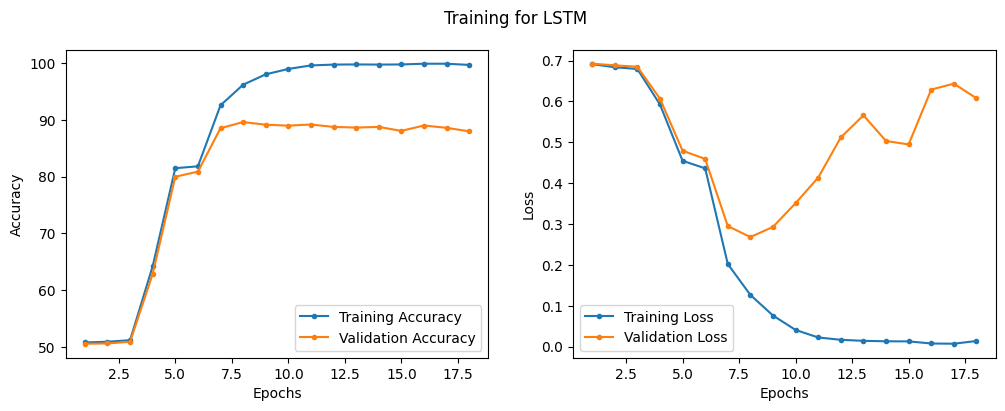

In [30]:
test_loss, test_acc = post_training(trained_model, loss_fn, test_loader, history_model, 'LSTM')

In [45]:
model, optimizer, max_accuracy, best_model = load_checkpoint(model, optimizer, '/kaggle/working/LSTM_checkpoint.pth.tar')
print(f'Best Valid Accuracy = {max_accuracy:.2f} %')
model.load_state_dict(best_model)
print(f'Test Accuracy = {get_accuracy(model, test_loader, loss_fn)[0]} %')

Best Valid Accuracy = 89.59 %
Test Accuracy = 87.6 %
